In [1]:
from scipy import stats as sp_stats
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load data
df = pd.read_csv('datasets/cleaned/merged_fx_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)

print(f"\nDataset loaded: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")


Dataset loaded: 4217 observations
Date range: 2008-01-02 00:00:00 to 2024-12-31 00:00:00


In [ ]:
df.columns

In [3]:
df = df.drop(columns=['MidRate', 'Selling', 'MPR'])

In [ ]:
df.columns

In [4]:
target = 'Buying'

In [5]:
def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{name}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] <= 0.05:
        print(f"✓ Series is STATIONARY (reject H0, p={result[1]:.4f})")
        return True, 0
    else:
        print(
            f"⚠ Series is NON-STATIONARY (fail to reject H0, p={result[1]:.4f})")
        return False, result[1]

In [6]:
# Test original series
is_stationary, p_value = adf_test(df[target], "Original Series (Buying Rate)")

# Test first difference
df['Buying_diff1'] = df[target].diff()
is_stationary_d1, p_value_d1 = adf_test(df['Buying_diff1'], "First Difference")

# Test second difference if needed
if not is_stationary_d1:
    df['Buying_diff2'] = df['Buying_diff1'].diff()
    is_stationary_d2, p_value_d2 = adf_test(
        df['Buying_diff2'], "Second Difference")
    d_order = 2
else:
    d_order = 1


Original Series (Buying Rate)
ADF Statistic: 1.027278
p-value: 0.994546
Critical Values:
  1%: -3.4319
  5%: -2.8622
  10%: -2.5671
⚠ Series is NON-STATIONARY (fail to reject H0, p=0.9945)

First Difference
ADF Statistic: -13.595800
p-value: 0.000000
Critical Values:
  1%: -3.4319
  5%: -2.8622
  10%: -2.5671
✓ Series is STATIONARY (reject H0, p=0.0000)


In [7]:
# Determine differencing order
if is_stationary:
    d_order = 0
    print(f"\n→ Recommended differencing order (d): {d_order}")
elif is_stationary_d1:
    d_order = 1
    print(f"\n→ Recommended differencing order (d): {d_order}")
else:
    d_order = 2
    print(f"\n→ Recommended differencing order (d): {d_order}")


→ Recommended differencing order (d): 1


In [8]:
# Use differenced series for ACF/PACF if non-stationary
if d_order == 0:
    analysis_series = df[target].dropna()
    series_name = "Original Series"
elif d_order == 1:
    analysis_series = df['Buying_diff1'].dropna()
    series_name = "First Difference"
else:
    analysis_series = df['Buying_diff2'].dropna()
    series_name = "Second Difference"

In [9]:
# Calculate ACF and PACF
acf_values = acf(analysis_series, nlags=40)
pacf_values = pacf(analysis_series, nlags=40)

In [10]:
# Suggest p and q based on ACF/PACF
# PACF cuts off at lag p → suggests AR(p)
# ACF cuts off at lag q → suggests MA(q)

# Find where PACF becomes insignificant (within confidence interval)
conf_interval = 1.96 / np.sqrt(len(analysis_series))
pacf_significant = np.where(np.abs(pacf_values[1:]) > conf_interval)[0]
if len(pacf_significant) > 0:
    suggested_p = min(pacf_significant[-1] + 1, 5)  # Cap at 5
else:
    suggested_p = 0

In [11]:
# Find where ACF becomes insignificant
acf_significant = np.where(np.abs(acf_values[1:]) > conf_interval)[0]
if len(acf_significant) > 0:
    suggested_q = min(acf_significant[-1] + 1, 5)  # Cap at 5
else:
    suggested_q = 0

print(f"\nAnalysis performed on: {series_name}")
print(f"Suggested AR order (p): {suggested_p}")
print(f"Suggested MA order (q): {suggested_q}")
print(f"Differencing order (d): {d_order}")


Analysis performed on: First Difference
Suggested AR order (p): 5
Suggested MA order (q): 5
Differencing order (d): 1


In [12]:
try:
    # Try different periods
    for period in [7, 30, 90]:
        if len(df) >= 2 * period:
            decomposition = seasonal_decompose(
                df[target].dropna(), model='additive', period=period)
            seasonal_strength = np.var(
                decomposition.seasonal) / np.var(decomposition.seasonal + decomposition.resid)
            print(
                f"Period {period} days - Seasonal Strength: {seasonal_strength:.4f}")

            if seasonal_strength > 0.1:
                print(f"  → Moderate to strong seasonality detected")
                seasonal_period = period
            else:
                print(f"  → Weak seasonality")

    # Use 30-day period as default for monthly patterns
    seasonal_period = 30
    print(f"\n→ Using seasonal period: {seasonal_period} days for SARIMAX")
except Exception as e:
    print(f"Could not perform seasonal decomposition: {e}")
    seasonal_period = None

Period 7 days - Seasonal Strength: 0.0020
  → Weak seasonality
Period 30 days - Seasonal Strength: 0.0077
  → Weak seasonality
Period 90 days - Seasonal Strength: 0.0183
  → Weak seasonality

→ Using seasonal period: 30 days for SARIMAX


In [13]:
# Use last 20% for testing
test_size = int(len(df) * 0.2)
train_size = len(df) - test_size

train = df.iloc[:train_size]
test = df.iloc[train_size:]

print(
    f"Training set: {len(train)} observations ({train.index.min()} to {train.index.max()})")
print(
    f"Test set: {len(test)} observations ({test.index.min()} to {test.index.max()})")

Training set: 3374 observations (2008-01-02 00:00:00 to 2021-08-09 00:00:00)
Test set: 843 observations (2021-08-10 00:00:00 to 2024-12-31 00:00:00)


In [14]:
# Define parameter ranges
p_range = range(0, min(suggested_p + 2, 6))
d_range = [d_order]  # Use determined differencing order
q_range = range(0, min(suggested_q + 2, 6))

# Grid search (limit to avoid excessive computation)
print("\nPerforming grid search for optimal ARIMA(p,d,q) parameters...")
print("Testing combinations (this may take a few minutes)...")


Performing grid search for optimal ARIMA(p,d,q) parameters...
Testing combinations (this may take a few minutes)...


In [15]:
best_aic = np.inf
best_params = None
best_model = None

results = []

# Limit combinations for efficiency
max_combinations = 30
all_combinations = list(itertools.product(p_range, d_range, q_range))

# Sample combinations if too many
if len(all_combinations) > max_combinations:
    print(
        f"Total combinations: {len(all_combinations)}, sampling {max_combinations} for efficiency")
    np.random.seed(42)
    sampled_indices = np.random.choice(
        len(all_combinations), max_combinations, replace=False)
    test_combinations = [all_combinations[i] for i in sampled_indices]
    # Always include suggested parameters
    if (suggested_p, d_order, suggested_q) not in test_combinations:
        test_combinations.append((suggested_p, d_order, suggested_q))
else:
    test_combinations = all_combinations

print(f"Testing {len(test_combinations)} parameter combinations...\n")

Total combinations: 36, sampling 30 for efficiency
Testing 30 parameter combinations...



In [16]:
for i, (p, d, q) in enumerate(test_combinations):
    try:
        model = ARIMA(train[target], order=(p, d, q))
        fitted_model = model.fit()
        aic = fitted_model.aic
        bic = fitted_model.bic

        results.append({
            'p': p, 'd': d, 'q': q,
            'AIC': aic, 'BIC': bic
        })

        if aic < best_aic:
            best_aic = aic
            best_params = (p, d, q)
            best_model = fitted_model

        if (i + 1) % 5 == 0:
            print(f"Tested {i + 1}/{len(test_combinations)} combinations...")

    except Exception as e:
        continue

print(f"\n✓ Grid search complete!")
print(
    f"\nBest ARIMA parameters: ({best_params[0]}, {best_params[1]}, {best_params[2]})")
print(f"Best AIC: {best_aic:.2f}")

Tested 5/30 combinations...
Tested 10/30 combinations...
Tested 15/30 combinations...
Tested 20/30 combinations...
Tested 25/30 combinations...
Tested 30/30 combinations...

✓ Grid search complete!

Best ARIMA parameters: (5, 1, 1)
Best AIC: -7357.43


In [17]:
# Show top 5 models
results_df = pd.DataFrame(results).sort_values('AIC').head(10)
print("\nTop 10 ARIMA models by AIC:")
print(results_df.to_string(index=False))


Top 10 ARIMA models by AIC:
 p  d  q          AIC          BIC
 5  1  1 -7357.429985 -7314.565080
 5  1  0 -7356.802509 -7320.061162
 5  1  2 -7355.508181 -7306.519718
 5  1  3 -7353.615613 -7298.503592
 5  1  4 -7352.026125 -7290.790547
 1  1  2 -7351.963983 -7327.469752
 4  1  2 -7351.837876 -7308.972971
 1  1  3 -7351.116841 -7320.499052
 0  1  5 -7351.012316 -7314.270969
 5  1  5 -7350.247347 -7282.888210


In [18]:
print(f"\nFitting ARIMA{best_params} on training data...")
final_arima = ARIMA(train[target], order=(1,1,1))
arima_fitted = final_arima.fit()

print("\nModel Summary:")
arima_fitted.summary()


Fitting ARIMA(5, 1, 1) on training data...

Model Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Buying   No. Observations:                 3374
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3675.315
Date:                Fri, 17 Oct 2025   AIC                          -7344.631
Time:                        08:20:02   BIC                          -7326.260
Sample:                             0   HQIC                         -7338.062
                               - 3374                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0553      0.006     -9.580      0.000      -0.067      -0.044
ma.L1         -0.6869      0.005   -130.433      0.000      -0.697      -0.677
sigma2         0.0066   1.35e-05    491.357      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):          12146111.11
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                           -14.15
Prob(H) (two-sided):                  0.00   Kurtosis:                       295.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
# Select exogenous variables (macro indicators)
exogenous_features = ['GhInflationRate', 'BrentOil', 'Gold',
                      'GhInterestRate', 'USInflationRate', 'USInterestRate', 'Imports', 'Exports', 'NetForeignAssets', 'NIR']

# Check available features
available_exogenous_features = [
    col for col in exogenous_features if col in df.columns]
print(f"\nExogenous variables: {', '.join(available_exogenous_features)}")

# Handle missing values in exogenous variables
for col in available_exogenous_features:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

# Prepare exogenous data
train_exogenous = train[available_exogenous_features]
test_exogenous = test[available_exogenous_features]

# Define seasonal order (P, D, Q, s)
if seasonal_period:
    seasonal_order = (1, 1, 1, seasonal_period)
else:
    seasonal_order = (0, 0, 0, 0)

print(f"\nSeasonal order: {seasonal_order}")


Exogenous variables: GhInflationRate, BrentOil, Gold, GhInterestRate, USInflationRate, USInterestRate, Imports, Exports, NetForeignAssets, NIR

Seasonal order: (1, 1, 1, 30)


In [20]:
# Try different SARIMAX configurations
print("\nTesting SARIMAX configurations...")

sarimax_configs = [
    (best_params, seasonal_order),
    ((1, d_order, 1), seasonal_order),
    ((2, d_order, 2), seasonal_order),
]


Testing SARIMAX configurations...


In [21]:
best_sarimax_aic = np.inf
best_sarimax_params = None
best_sarimax_model = None

for order, seasonal in sarimax_configs:
    try:
        print(f"\nTrying SARIMAX{order}x{seasonal}...")
        model = SARIMAX(train[target],
                        exog=train_exogenous,
                        order=order,
                        seasonal_order=seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        fitted = model.fit(disp=False, maxiter=200)

        print(f"  AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")

        if fitted.aic < best_sarimax_aic:
            best_sarimax_aic = fitted.aic
            best_sarimax_params = (order, seasonal)
            best_sarimax_model = fitted

    except Exception as e:
        print(f"  Failed: {str(e)[:100]}")


Trying SARIMAX(5, 1, 1)x(1, 1, 1, 30)...
  AIC: -6319.39, BIC: -6203.41

Trying SARIMAX(1, 1, 1)x(1, 1, 1, 30)...
  AIC: -6370.34, BIC: -6278.76

Trying SARIMAX(2, 1, 2)x(1, 1, 1, 30)...
  AIC: -6374.20, BIC: -6270.42


In [22]:
# ARIMA predictions
print("\n1. ARIMA Model Predictions:")
arima_pred = arima_fitted.forecast(steps=len(test))
arima_pred_series = pd.Series(arima_pred, index=test.index)

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(test[target], arima_pred))
arima_mae = mean_absolute_error(test[target], arima_pred)
arima_mape = np.mean(np.abs((test[target] - arima_pred) / test[target])) * 100
arima_r2 = r2_score(test[target], arima_pred)

print(f"  RMSE: {arima_rmse:.4f}")
print(f"  MAE: {arima_mae:.4f}")
print(f"  MAPE: {arima_mape:.2f}%")
print(f"  R²: {arima_r2:.4f}")


1. ARIMA Model Predictions:
  RMSE: 5.7084
  MAE: 4.7438
  MAPE: nan%
  R²: -2.2320


In [23]:
# SARIMAX predictions
if best_sarimax_model:
    print("\n2. SARIMAX Model Predictions:")
    sarimax_pred = best_sarimax_model.forecast(steps=len(test), exog=test_exogenous)
    sarimax_pred_series = pd.Series(sarimax_pred, index=test.index)

    sarimax_rmse = np.sqrt(mean_squared_error(test[target], sarimax_pred))
    sarimax_mae = mean_absolute_error(test[target], sarimax_pred)
    sarimax_mape = np.mean(
        np.abs((test[target] - sarimax_pred) / test[target])) * 100
    sarimax_r2 = r2_score(test[target], sarimax_pred)

    print(f"  RMSE: {sarimax_rmse:.4f}")
    print(f"  MAE: {sarimax_mae:.4f}")
    print(f"  MAPE: {sarimax_mape:.2f}%")
    print(f"  R²: {sarimax_r2:.4f}")

# Naive forecast (persistence model) for comparison
naive_pred = train[target].iloc[-1]
naive_rmse = np.sqrt(mean_squared_error(test[target], [naive_pred]*len(test)))
naive_mae = mean_absolute_error(test[target], [naive_pred]*len(test))
naive_mape = np.mean(np.abs((test[target] - naive_pred) / test[target])) * 100

print("\n3. Naive Baseline (Last Value):")
print(f"  RMSE: {naive_rmse:.4f}")
print(f"  MAE: {naive_mae:.4f}")
print(f"  MAPE: {naive_mape:.2f}%")


2. SARIMAX Model Predictions:
  RMSE: 5.2883
  MAE: 4.3178
  MAPE: nan%
  R²: -1.7738

3. Naive Baseline (Last Value):
  RMSE: 5.7009
  MAE: 4.7348
  MAPE: 38.85%


In [24]:
print("\n" + "="*80)
print("RESIDUAL ANALYSIS")
print("="*80)

arima_residuals = arima_fitted.resid

print("\nARIMA Residual Statistics:")
print(f"  Mean: {arima_residuals.mean():.6f}")
print(f"  Std Dev: {arima_residuals.std():.4f}")
print(f"  Skewness: {arima_residuals.skew():.4f}")
print(f"  Kurtosis: {arima_residuals.kurtosis():.4f}")

# Ljung-Box test for residual autocorrelation
lb_test = acorr_ljungbox(arima_residuals, lags=[10, 20], return_df=True)
print("\nLjung-Box Test (checking for autocorrelation in residuals):")
print(lb_test)

if all(lb_test['lb_pvalue'] > 0.05):
    print("✓ Residuals show no significant autocorrelation")
else:
    print("⚠ Some autocorrelation remains in residuals")


RESIDUAL ANALYSIS

ARIMA Residual Statistics:
  Mean: 0.005132
  Std Dev: 0.0829
  Skewness: -12.9057
  Kurtosis: 275.8276

Ljung-Box Test (checking for autocorrelation in residuals):
      lb_stat  lb_pvalue
10  17.610741   0.061896
20  48.903110   0.000317
⚠ Some autocorrelation remains in residuals



GENERATING VISUALIZATIONS


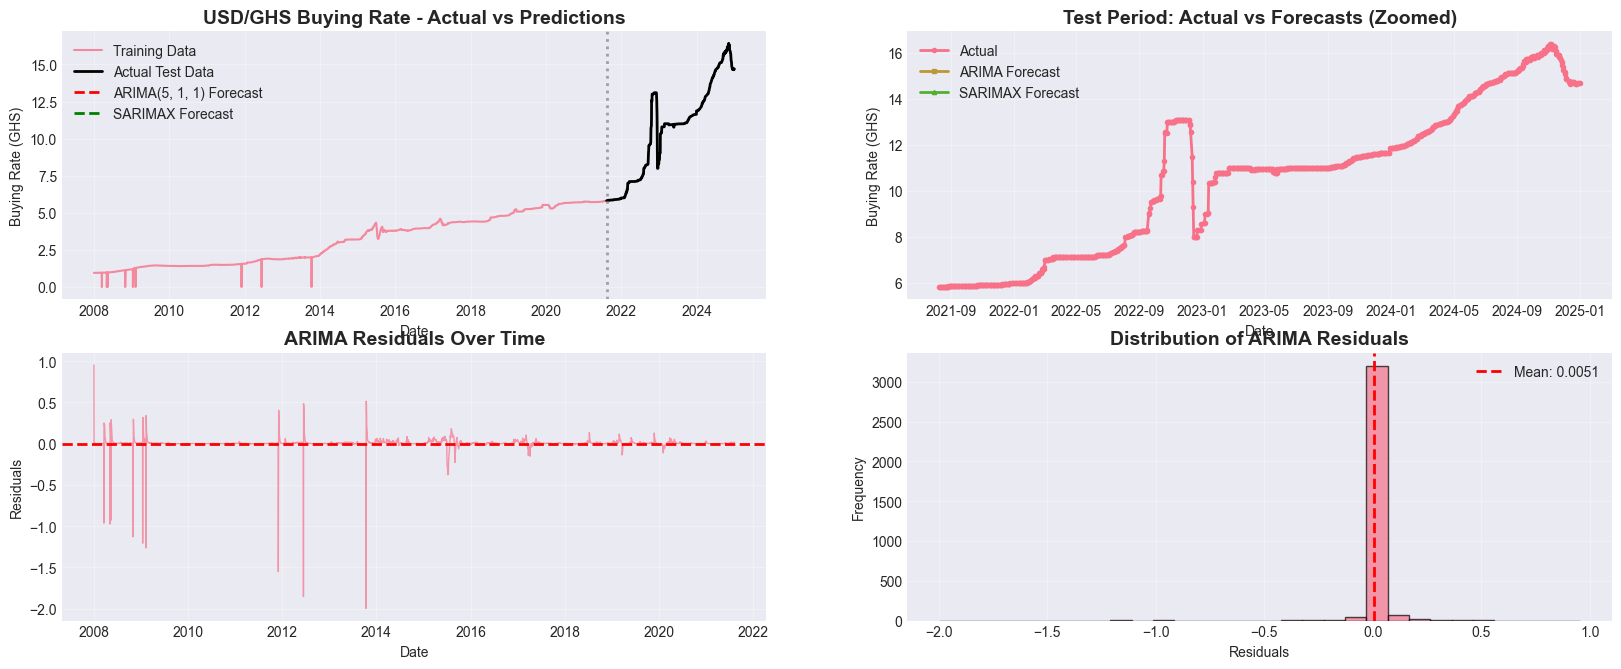

In [25]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Create comprehensive plot
fig = plt.figure(figsize=(20, 16))

# Plot 1: Time series with predictions
ax1 = plt.subplot(4, 2, 1)
plt.plot(train.index, train[target],
         label='Training Data', linewidth=1.5, alpha=0.8)
plt.plot(test.index, test[target],
         label='Actual Test Data', linewidth=2, color='black')
plt.plot(test.index, arima_pred_series, label=f'ARIMA{best_params} Forecast',
         linewidth=2, linestyle='--', color='red')
if best_sarimax_model:
    plt.plot(test.index, sarimax_pred_series, label='SARIMAX Forecast',
             linewidth=2, linestyle='--', color='green')
plt.axvline(test.index[0], color='gray', linestyle=':', linewidth=2, alpha=0.7)
plt.title('USD/GHS Buying Rate - Actual vs Predictions',
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Buying Rate (GHS)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Forecast vs Actual (Test Period Only)
ax2 = plt.subplot(4, 2, 2)
plt.plot(test.index, test[target], label='Actual',
         linewidth=2, marker='o', markersize=3)
plt.plot(test.index, arima_pred_series, label='ARIMA Forecast',
         linewidth=2, marker='s', markersize=3)
if best_sarimax_model:
    plt.plot(test.index, sarimax_pred_series, label='SARIMAX Forecast',
             linewidth=2, marker='^', markersize=3)
plt.title('Test Period: Actual vs Forecasts (Zoomed)',
          fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Buying Rate (GHS)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Residuals over time
ax3 = plt.subplot(4, 2, 3)
plt.plot(arima_residuals.index, arima_residuals, linewidth=1, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('ARIMA Residuals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Plot 4: Residual distribution
ax4 = plt.subplot(4, 2, 4)
plt.hist(arima_residuals, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(arima_residuals.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {arima_residuals.mean():.4f}')
plt.title('Distribution of ARIMA Residuals', fontsize=14, fontweight='bold')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

✓ Comprehensive results saved as 'arima_sarimax_comprehensive_results.png'


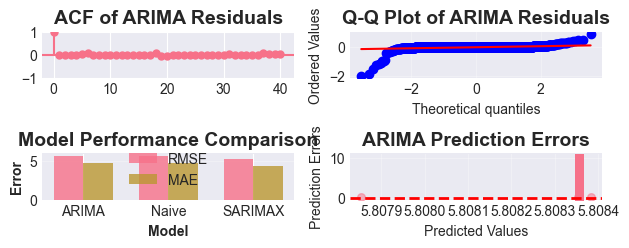

In [26]:
# Plot 5: ACF of residuals
ax5 = plt.subplot(4, 2, 5)
plot_acf(arima_residuals, lags=40, ax=ax5)
plt.title('ACF of ARIMA Residuals', fontsize=14, fontweight='bold')

# Plot 6: Q-Q plot of residuals
ax6 = plt.subplot(4, 2, 6)
sp_stats.probplot(arima_residuals, dist="norm", plot=ax6)
plt.title('Q-Q Plot of ARIMA Residuals', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot 7: Model comparison
ax7 = plt.subplot(4, 2, 7)
models = ['ARIMA', 'Naive']
rmse_values = [arima_rmse, naive_rmse]
mae_values = [arima_mae, naive_mae]

if best_sarimax_model:
    models.append('SARIMAX')
    rmse_values.append(sarimax_rmse)
    mae_values.append(sarimax_mae)

x = np.arange(len(models))
width = 0.35

bars1 = ax7.bar(x - width/2, rmse_values, width, label='RMSE', alpha=0.8)
bars2 = ax7.bar(x + width/2, mae_values, width, label='MAE', alpha=0.8)

ax7.set_xlabel('Model', fontweight='bold')
ax7.set_ylabel('Error', fontweight='bold')
ax7.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax7.set_xticks(x)
ax7.set_xticklabels(models)
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# Plot 8: Prediction errors
ax8 = plt.subplot(4, 2, 8)
arima_errors = test[target].values - arima_pred
plt.scatter(arima_pred, arima_errors, alpha=0.5, s=30)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Prediction Errors')
plt.title('ARIMA Prediction Errors', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('arima_sarimax_comprehensive_results.png',
            dpi=300, bbox_inches='tight')
print("✓ Comprehensive results saved as 'arima_sarimax_comprehensive_results.png'")

In [27]:
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Naive Baseline', f'ARIMA{best_params}'],
    'RMSE': [naive_rmse, arima_rmse],
    'MAE': [naive_mae, arima_mae],
    'MAPE (%)': [naive_mape, arima_mape],
    'R²': [np.nan, arima_r2]
})

if best_sarimax_model:
    comparison = pd.concat([comparison, pd.DataFrame({
        'Model': [f'SARIMAX{best_sarimax_params[0]}x{best_sarimax_params[1]}'],
        'RMSE': [sarimax_rmse],
        'MAE': [sarimax_mae],
        'MAPE (%)': [sarimax_mape],
        'R²': [sarimax_r2]
    })], ignore_index=True)

print("\n" + comparison.to_string(index=False))

# Determine best model
if best_sarimax_model and sarimax_rmse < arima_rmse:
    best_overall = 'SARIMAX'
    best_rmse = sarimax_rmse
    improvement = ((naive_rmse - sarimax_rmse) / naive_rmse) * 100
else:
    best_overall = 'ARIMA'
    best_rmse = arima_rmse
    improvement = ((naive_rmse - arima_rmse) / naive_rmse) * 100

print(f"\n✓ BEST MODEL: {best_overall}")
print(f"  Improvement over naive baseline: {improvement:.2f}%")

print("\n" + "="*80)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\n1. MODEL PERFORMANCE:")
if arima_r2 > 0.8:
    print("   ✓ Excellent model fit (R² > 0.8)")
elif arima_r2 > 0.6:
    print("   ✓ Good model fit (R² > 0.6)")
else:
    print("   ⚠ Moderate model fit - room for improvement")

print("\n2. RESIDUAL ANALYSIS:")
if abs(arima_residuals.mean()) < 0.01:
    print("   ✓ Residuals centered around zero (unbiased)")
else:
    print("   ⚠ Residuals show slight bias")

print("\n3. EXOGENOUS VARIABLES:")
if best_sarimax_model and sarimax_rmse < arima_rmse:
    improvement_pct = ((arima_rmse - sarimax_rmse) / arima_rmse) * 100
    print(f"   ✓ SARIMAX outperforms ARIMA by {improvement_pct:.2f}%")
    print("   → Macroeconomic indicators add predictive value")
else:
    print("   ⚠ Limited improvement from exogenous variables")
    print("   → Consider feature engineering or alternative models")

print("\n4. NEXT STEPS:")
print("   • Consider machine learning models (XGBoost, LightGBM)")
print("   • Engineer features: lags, rolling statistics, interactions")
print("   • Implement walk-forward validation")
print("   • Create ensemble of ARIMA + ML models")

print("\n" + "="*80)
print("ARIMA/SARIMAX MODELING COMPLETE")
print("="*80)


MODEL PERFORMANCE SUMMARY

                         Model     RMSE      MAE  MAPE (%)        R²
                Naive Baseline 5.700889 4.734763 38.851572       NaN
                ARIMA(5, 1, 1) 5.708404 4.743809       NaN -2.232034
SARIMAX(2, 1, 2)x(1, 1, 1, 30) 5.288252 4.317844       NaN -1.773773

✓ BEST MODEL: SARIMAX
  Improvement over naive baseline: 7.24%

KEY INSIGHTS & RECOMMENDATIONS

1. MODEL PERFORMANCE:
   ⚠ Moderate model fit - room for improvement

2. RESIDUAL ANALYSIS:
   ✓ Residuals centered around zero (unbiased)

3. EXOGENOUS VARIABLES:
   ✓ SARIMAX outperforms ARIMA by 7.36%
   → Macroeconomic indicators add predictive value

4. NEXT STEPS:
   • Consider machine learning models (XGBoost, LightGBM)
   • Engineer features: lags, rolling statistics, interactions
   • Implement walk-forward validation
   • Create ensemble of ARIMA + ML models

ARIMA/SARIMAX MODELING COMPLETE
